In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *
from helpers_similarity import *
from helpers_optimization import *
from scipy.optimize import minimize
import time


In [3]:
mu = 0
sigma_u = 1
sigma_v = 1
sigma = 0
lambda_reg = 0.1
parameters = {}
d_dim = 2

## Bradley-Terry-Luce (BTL) model

Calculate the difference between each pair of elements in the 2D array X. Then, generate the probability matrix by applying the logistic function $$P(x) = \frac{e^{x}}{1 + e^{x}}$$ element-wise to the difference matrix, where x is the difference between two elements :

In [4]:
def generate_P_BT_Luce(X, n_users, alpha=1.0): # tha larger alpha, the flatter and noisier the sigmoid is !! read abt it !!
    # this method breaks down when n_users*n_movies is large (e.g., more than a million).
    diff = alpha*np.subtract.outer(X, X) 
    X_diff= np.array([diff[i, :, i, :] for i in range(n_users)])
    P = np.exp(X_diff) / (1 + np.exp(X_diff))
    
    return P, X_diff


Generate pairwise comparison data $Y_{ijk} = \pm 1$ for each user and item. The output Y is a $3D$ tensor with the shape $(n\_users, n\_items, n\_items)$. Each entry $Y[i,j,k]$ corresponds to whether user i prefers item j over item k. For example, line 0 of Y corresponds to the pairwise comparisons of user 0 with all items: $Y[0,0,:]$ represents whether user 0 prefers item 0 over all other items $(item\_0, item\_1, item\_2, etc..)$, and so on.

In [5]:
def pairwise_comparisons(P):
    
    Y = np.random.binomial(n=1, p=P, size=P.shape) 
    Y = np.where(Y == 0, -1, Y)
    
    return Y

In [135]:
n_users = [10, 20, 40, 80, 160]
times = []
for n in n_users:
    start = time.time()
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n, n)
    P, _ = generate_P_BT_Luce(X, n)
    Y = pairwise_comparisons(P)
    times.append(time.time() - start)
print(times)

KeyboardInterrupt: 

In [6]:
def hinge_loss(x):
    return np.maximum(0, 1 - x)**2 

## Minimization of U while V fixed, and V while U fixed

Explain what we're doing here

In [7]:
def sum_loss(U, V, Y):
    n, m, _ = Y.shape
    loss = 0
    for j in range(m):
        v = V[:,j] - V.T
        # for i in range(n):
            # for k in range(j):
            #     if Y[i, j, k] != 0:
            #         v = V[:,j] - V[:,k]
            #         x = np.dot(U[:,i], v)
            #         loss += hinge_loss(Y[i, j, k] * x)
            # x = np.dot(v, U[:,i])
        x = np.dot(v, U)
        loss += np.sum(hinge_loss(Y[:,j]*x.T)[:,:j])
    return loss

In [20]:
n_users = [10, 20, 40, 80, 160]
times2 = []
for n in n_users:
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n, n)
    P, _ = generate_P_BT_Luce(X, n)
    Y = pairwise_comparisons(P)
    start = time.time()
    loss = sum_loss(U, V, Y)
    times2.append(time.time() - start)
print(times2)

KeyboardInterrupt: 

In [8]:
def loss_U(U, Y, V, lambda_reg, d_dim, n_users):
    U = U.reshape((d_dim, n_users))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(U, 'fro') ** 2 
    
    return loss + reg

In [9]:
def loss_V(V, Y, U, lambda_reg, d_dim, n_movies):
    V = V.reshape((d_dim, n_movies))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(V, 'fro') ** 2
    
    return loss + reg

In [10]:
def optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times):
    
    start = time.perf_counter()
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    P, _ = generate_P_BT_Luce(X, n_users)
    Y = pairwise_comparisons(P)
    U0 = np.random.normal(mu, sigma_u, d_dim*n_users)
    V0 = np.random.normal(mu, sigma_u, d_dim*n_movies)
    preproc_times.append(time.perf_counter() - start)
    
    start = time.perf_counter()
    U_res = minimize(loss_U, U0, args=(Y, V, lambda_reg, d_dim, n_users), method='L-BFGS-B')
    U_times.append(time.perf_counter() - start)

    start = time.perf_counter()
    V_res = minimize(loss_V, V0, args=(Y, U, lambda_reg, d_dim, n_movies), method='L-BFGS-B')
    V_times.append(time.perf_counter() - start)

    U_result = 0
    if U_res.success :
        U_result = U_res.x.reshape((d_dim, n_users))
    else :
        print('Minimization failure for U')
        print(U_res.message)
        U_result = U_res.x.reshape((d_dim, n_users))
    diff_norm_U = np.linalg.norm(U - U_result, 'fro') 
    
    V_result = 0
    if V_res.success :
        V_result = V_res.x.reshape((d_dim, n_movies))
    else :
        print('Minimization failure for V')
        print(V_res.message)
        V_result = V_res.x.reshape((d_dim, n_movies))
    V_base = V.T - V[:,0]
    V_result_base = V_result.T - V_result[:,0]
    diff_norm_V = np.linalg.norm(V_base - V_result_base, 'fro')
    
    X_result = np.matmul(U_result.T,V_result)
    P_result, _ = generate_P_BT_Luce(X_result, n_users)
    diff_norm_P = np.linalg.norm(P - P_result)
    return diff_norm_U, diff_norm_V, diff_norm_P


In [11]:
def norm_results(d_dim, n_users, n_movies, preproc_times, U_times, V_times, nb_iter):
    avg_U = 0
    avg_V = 0
    avg_P = 0
    n_U = 0
    n_V = 0
    n_P = 0
    for i in range(nb_iter):
        diff_U, diff_V, diff_P = optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times)
        if diff_U is not np.nan:
            avg_U += diff_U
            n_U += 1
        if diff_V is not np.nan:
            avg_V += diff_V
            n_V += 1
        if diff_P is not np.nan:
            avg_P += diff_P
            n_P += 1
    print(avg_U, n_U)
    print(avg_V, n_V)
    print(avg_P, n_P)
    avg_U /= n_U
    avg_V /= n_V
    avg_P /= n_P
    return avg_U, avg_V, avg_P

In [117]:
N_vals = [10, 20, 30, 40, 50]
M_vals = [10, 20, 30, 40, 50]
nb_iter = 100
preproc_times = []
U_times = []
V_times = []
data = []
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(i,j)
        avg_U, avg_V, avg_P = norm_results(d_dim, N_vals[i], M_vals[j], preproc_times, U_times, V_times, nb_iter)
        row= [N_vals[i], M_vals[j], avg_U, avg_V, avg_P]
        data.append(row)

0 0
271.15261893211886 100
345.6716763620258 100
641.5038081394654 100
0 1
280.6037138430318 100
532.3451256696152 100
1365.7463951115583 100
0 2
280.48690079237383 100
657.0730418601091 100
2065.884754234701 100
0 3
279.6074172134757 100
777.3386667805332 100
2789.9566364216826 100
0 4
273.4232621980497 100
871.7321117790345 100
3444.8820505348763 100
1 0
388.8569517765121 100
375.31115035672894 100
920.7505726429034 100
1 1
404.5779832409185 100
509.2758785911222 100
1929.004110552371 100
1 2
412.0854974005039 100
651.6728820297224 100
2949.307945518643 100
1 3
406.18278464303444 100
770.7508508755266 100
3962.0611606395964 100
1 4
408.31546291822826 100
822.1335798837179 100
4957.421669684983 100
2 0
494.6117442400882 100
376.38420905102254 100
1153.1190343864391 100
2 1
502.67974870245416 100
520.3203271875853 100
2401.0749573458816 100
2 2
493.9643741794918 100
675.3182179376661 100
3605.560929398041 100
2 3
496.42686652000714 100
782.5776366239921 100
4872.940887481076 100
2 4
49

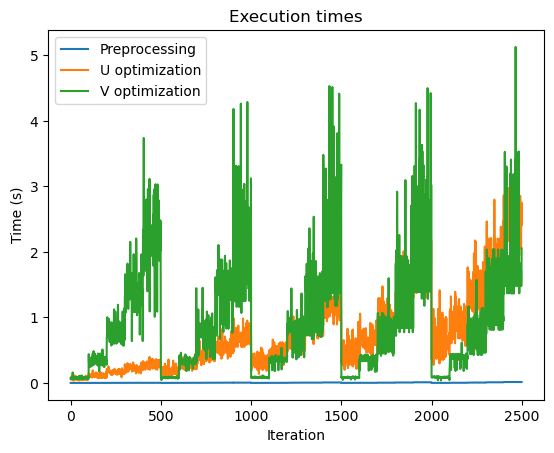

In [118]:
plt.plot( preproc_times, label='Preprocessing')
plt.plot( U_times, label='U optimization')
plt.plot( V_times, label='V optimization')
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Execution times')
plt.legend()
plt.show()

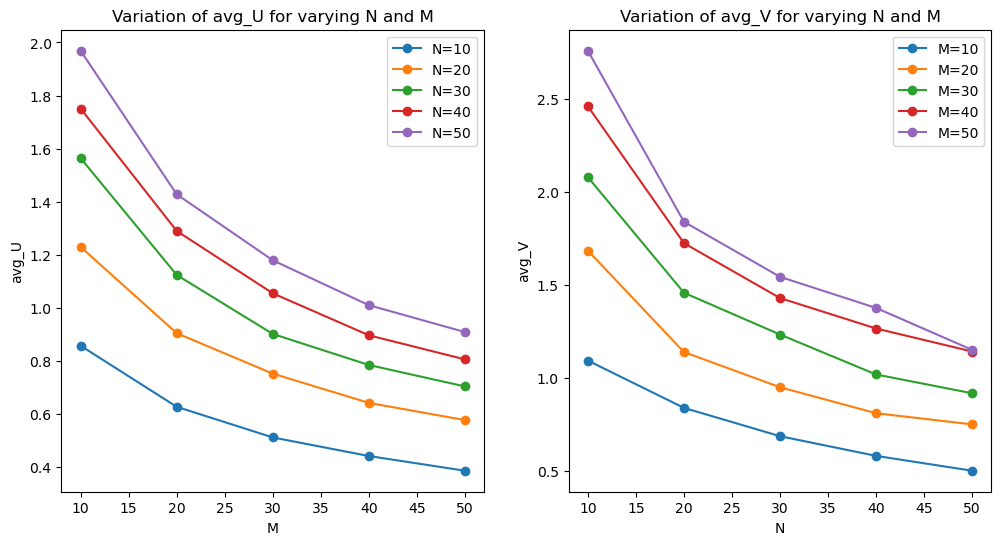

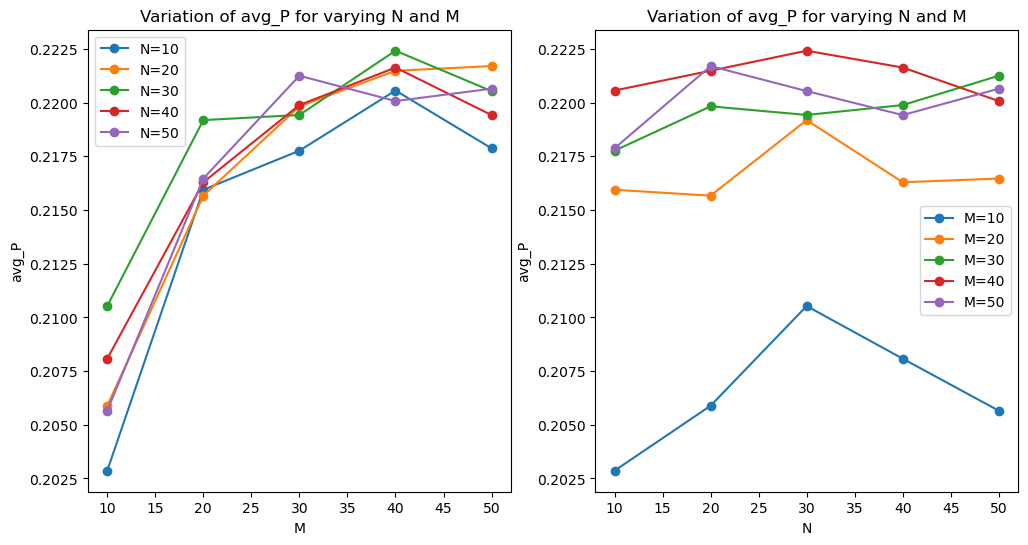

In [119]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V', 'avg_P'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U']/np.sqrt(df_m['M']), marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V']/np.sqrt(df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_P']/np.sqrt(n*df_m['M']*df_m['M']), marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_P']/np.sqrt(m*m*df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_P')
ax1.set_title('Variation of avg_P for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_P')
ax2.set_title('Variation of avg_P for varying N and M')
ax2.legend()

plt.show()

## Alternating Minimization of U and V

Explain what we're doing here

In [29]:
def initialize_parameters(sigma_u, sigma_v, mu, sigma, d_dims, n_users, n_movies, lambda_reg):  
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    P, _ = generate_P_BT_Luce(X, n_users)
    Y = pairwise_comparisons(P)  
    U_init = np.random.normal(mu, sigma_u, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_v, (d_dims, n_movies))   
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['P'] = P
    parameters['Y'] = Y
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_reg'] = lambda_reg

In [30]:
def update_parameters(n_users, n_movies):
    U_prev = parameters['U_result']
    V_prev = parameters['V_result']
    Y = parameters['Y']

    U_prev = U_prev.reshape((d_dim, n_users))
    V_prev = V_prev.reshape((d_dim, n_movies))

    U_result = minimize(loss_U, U_prev, args=(Y, V_prev, lambda_reg, d_dim, n_users), method='L-BFGS-B')
    V_result = minimize(loss_V, V_prev, args=(Y, U_prev, lambda_reg, d_dim, n_movies), method='L-BFGS-B')
    
    U_result = U_result.x.reshape((d_dim, n_users))
    V_result = V_result.x.reshape((d_dim, n_movies))
    
    parameters['U_result'] = U_result
    parameters['V_result'] = V_result

In [31]:
def loss(d_dim, n_users, n_movies):
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    Y = parameters['Y']
    lambda_reg = parameters['lambda_reg']

    loss_u = loss_U(U_result, Y, V_result, lambda_reg, d_dim, n_users) /(d_dim*n_users) # normalize by n_users or d_dim*n_users ??
    loss_v = loss_V(V_result, Y, U_result, lambda_reg, d_dim, n_movies) /(d_dim*n_movies)
    
    return loss_u, loss_v


In [40]:
def compare_results(n_users, n_movies):
    U = parameters['U']
    V = parameters['V']
    P = parameters['P']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    
    diff_norm_U = procrustes_norm(U, U_result, 1)  #np.linalg.norm(U - U_result, 'fro')
    V_base = V.T - V[:,0]
    V_result_base = V_result.T - V_result[:,0]
    diff_norm_V = procrustes_norm(V, V_result, 1) #procrustes_norm(V_base, V_result_base, 1)  #np.linalg.norm(V_base - V_result_base, 'fro')

    X_result = np.matmul(U_result.T, V_result)
    P_result, _ = generate_P_BT_Luce(X_result, n_users)
    diff_norm_P = np.linalg.norm(P - P_result)
    
    return diff_norm_U, diff_norm_V, diff_norm_P


In [37]:
def alt_minimization_U_V(d_dims, n_users, n_movies):
    initialize_parameters(sigma_u, sigma_v, mu, sigma, d_dims, n_users, n_movies, lambda_reg) 
    loss_u_vals = []
    loss_v_vals = []
    #while True:
    for i in range(20): # 50
        if len(loss_u_vals) > 2:
            if np.abs(loss_u_vals[-1] - loss_u_vals[-2]) < 0.01:
                break
        update_parameters(n_users, n_movies)

        loss_u, loss_v = loss(d_dim, n_users, n_movies)
        loss_u_vals.append(loss_u)
        loss_v_vals.append(loss_v) 
        if i % 10 == 0:
            print(f'loss_u: {loss_u}, loss_v: {loss_v}')      
                
    diff_norm_U, diff_norm_V, diff_norm_P = compare_results(n_users, n_movies)
    
    return diff_norm_U, diff_norm_V, diff_norm_P, loss_u_vals, loss_v_vals


In [38]:
def norm_results_altgd(d_dim, n_users, n_movies, nb_iter):
    avg_U = 0
    avg_V = 0
    avg_P = 0
    n_U = 0
    n_V = 0
    n_P = 0
    for i in range(nb_iter):
        diff_P, diff_U, diff_V, loss_u_vals, loss_v_vals = alt_minimization_U_V(d_dim, n_users, n_movies)
        if diff_U is not np.nan:
            avg_U += diff_U
            n_U += 1
        if diff_V is not np.nan:
            avg_V += diff_V
            n_V += 1
        if diff_P is not np.nan:
            avg_P += diff_P
            n_P += 1
    print(avg_U, n_U)
    print(avg_V, n_V)
    print(avg_P, n_P)
    avg_U /= n_U
    avg_V /= n_V
    avg_P /= n_P
    return avg_U, avg_V, avg_P, loss_u_vals, loss_v_vals


In [46]:
N_vals = [10, 30, 50]#, 30, 40, 50]
M_vals = [10, 30, 50]#, 30, 40, 50]
nb_iter = 5
preproc_times = []
U_times = []
V_times = []
data = []
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(f'N: {N_vals[i]}, M: {M_vals[j]}')
        avg_U, avg_V, avg_P, loss_u_vals, loss_v_vals = norm_results_altgd(d_dim, N_vals[i], M_vals[j], nb_iter)
        row= [N_vals[i], M_vals[j], avg_U, avg_V, avg_P]
        data.append(row)
        U_times.append(loss_u_vals)
        V_times.append(loss_v_vals)


        

N: 10, M: 10


/var/folders/y6/l6vpn95x35g0swp7xwnqndtc0000gn/T/ipykernel_988/2534261441.py:9: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  U_result = minimize(loss_U, U_prev, args=(Y, V_prev, lambda_reg, d_dim, n_users), method='L-BFGS-B')
/var/folders/y6/l6vpn95x35g0swp7xwnqndtc0000gn/T/ipykernel_988/2534261441.py:10: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  V_result = minimize(loss_V, V_prev, args=(Y, U_prev, lambda_reg, d_dim, n_movies), method='L-BFGS-B')


loss_u: 21.621391870238522, loss_v: 21.623887658478395
loss_u: 20.116783682847124, loss_v: 20.11906444087937
loss_u: 21.638421724620454, loss_v: 21.64342389639108
loss_u: 20.881073426846562, loss_v: 20.88655987875844
loss_u: 22.67493983491939, loss_v: 22.670332188671743
loss_u: 24.36380007891865, loss_v: 24.357075076106348
loss_u: 22.36551489052669, loss_v: 22.366068775205857
loss_u: 44.679452787690266, loss_v: 44.64619065133009
loss_u: 22.834285710880472, loss_v: 22.83420027489303
loss_u: 23.5938363055433, loss_v: 23.59322291588004
1.050877655623819e-30 5
58.15385854060618 5
5.925266414020391e-31 5
N: 10, M: 30
loss_u: 220.24957339624544, loss_v: 73.41846467102894
loss_u: 227.41180706371136, loss_v: 75.8062983216112
loss_u: 215.39821634136328, loss_v: 71.79979974299226
loss_u: 216.70083108344448, loss_v: 72.23497413843702
loss_u: 217.29311877540255, loss_v: 72.43306672045415
loss_u: 212.78163988510514, loss_v: 70.93001686630535
loss_u: 219.94086284437702, loss_v: 73.31443516167316
los

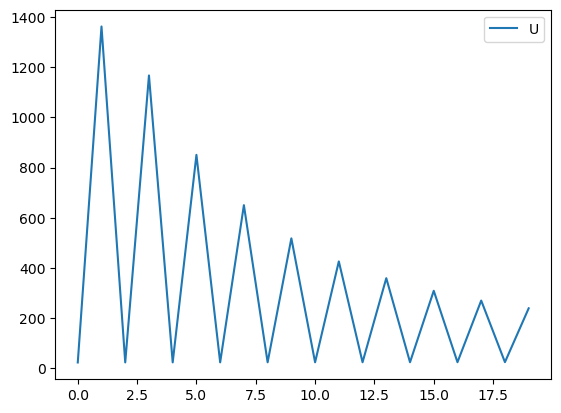

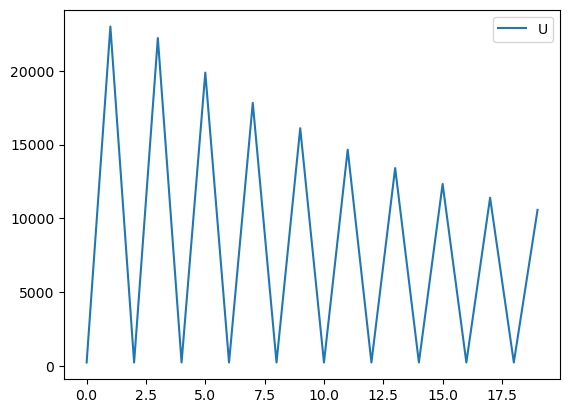

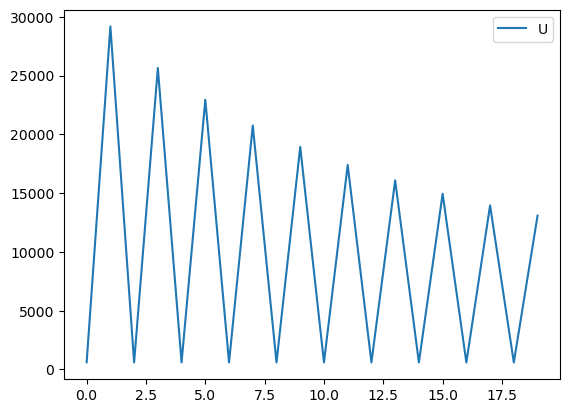

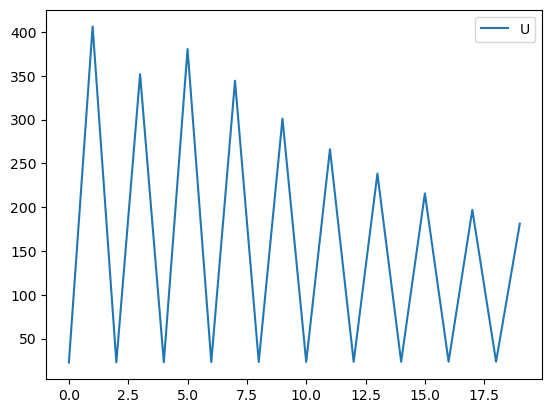

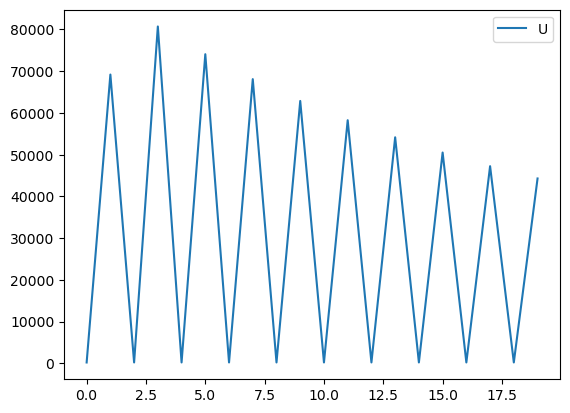

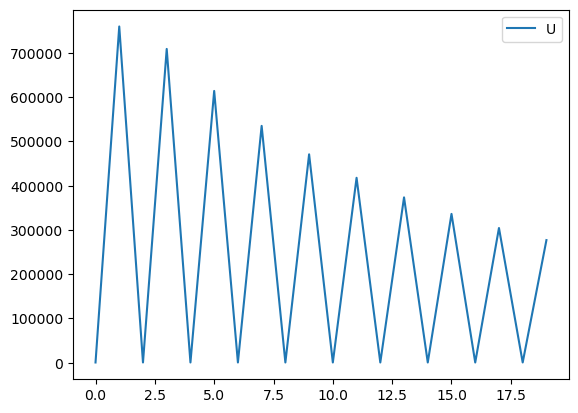

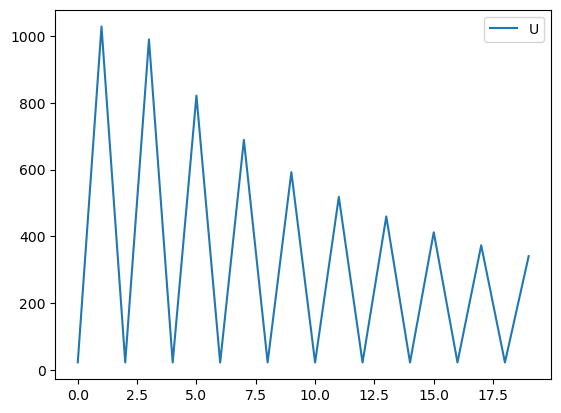

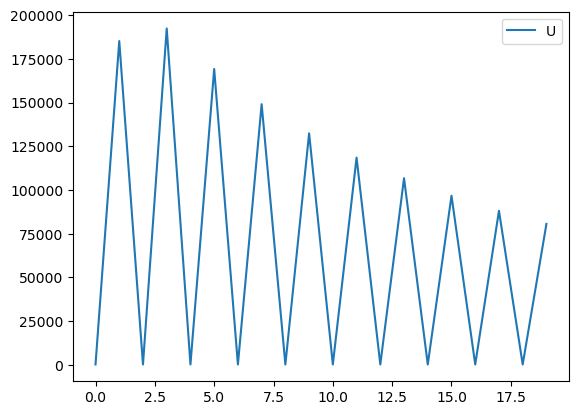

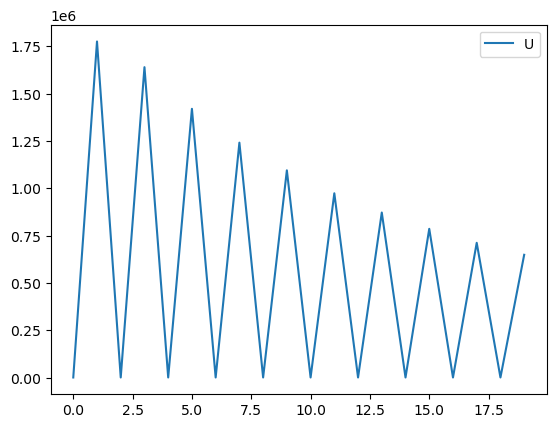

In [47]:
for i in range(len(U_times)):
    plt.plot(U_times[i], label='U')
    #plt.plot(V_times, label='V')
    plt.legend()
    plt.show()


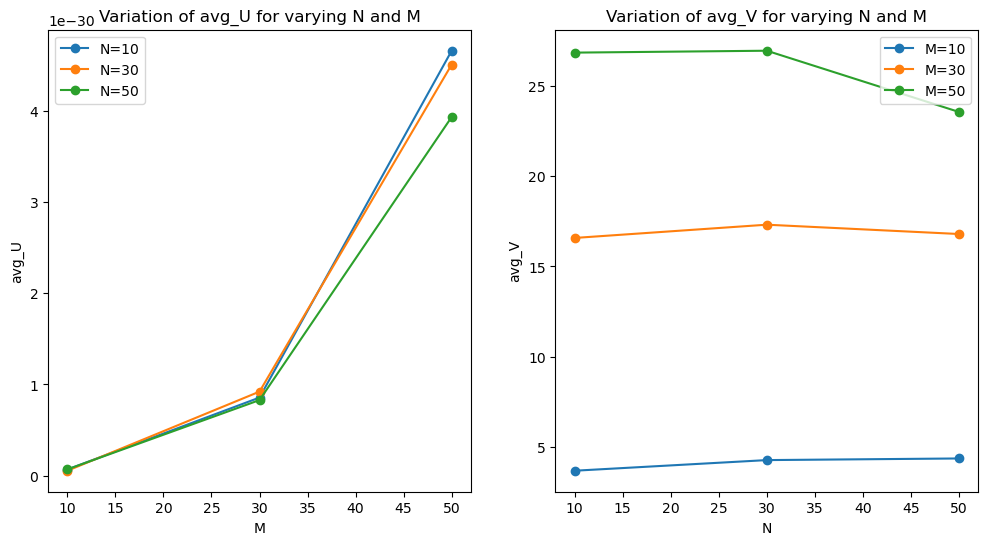

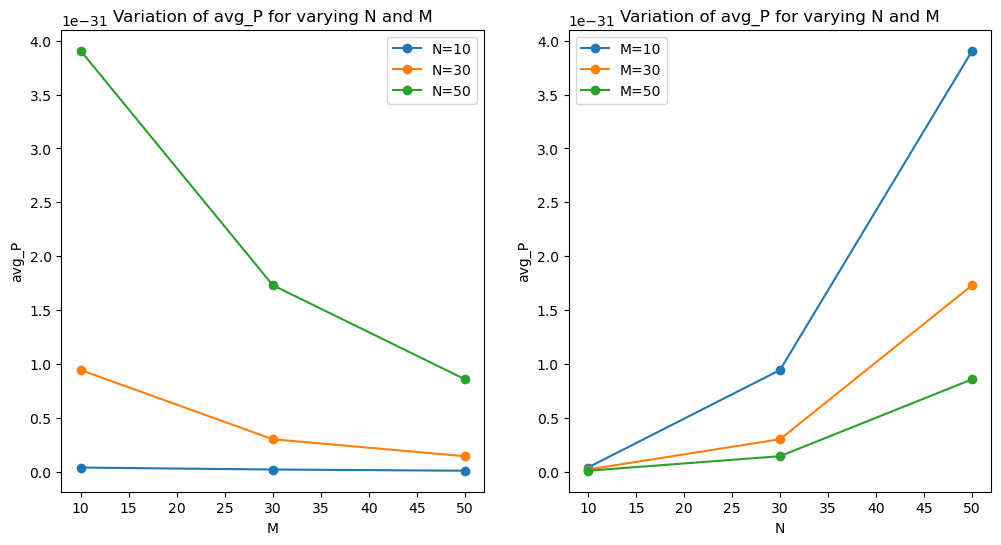

In [48]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V', 'avg_P'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U']/np.sqrt(df_m['M']), marker='o', label=f'N={n}') # why divide avg_U by M not N ?
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V']/np.sqrt(df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_P']/np.sqrt(n*df_m['M']*df_m['M']), marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_P']/np.sqrt(m*m*df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_P')
ax1.set_title('Variation of avg_P for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_P')
ax2.set_title('Variation of avg_P for varying N and M')
ax2.legend()

plt.show()